Running parameter set 1...
Best individual:
30.21243957576165 159.00054552534226 -185.5996182813223 -240.11601094312195 -98.83022786333814 -157.6087050068361 7.110554472419326 -11.923528561391485 -115.40565050801655 -113.56899272995032 -163.1267926089888 -26.657619815935213
Average fitness: 0.5208558072694176
Average number of generations: 24.0
Running parameter set 2...
Best individual:
-31.108170206626724 70.81280859808244 -39.521323211989326 -59.7435676535931 -69.6544841608806 -60.634793737446174 59.8974890933673 94.05775706836694 -160.83120640860872 -133.10935208456115 -169.81215805709255 -247.78298714134303
Average fitness: 0.6920795381913968
Average number of generations: 86.2
Running parameter set 3...
Best individual:
-7.677325440634236 77.73007730045177 -35.412437518389865 -68.76550458275277 -92.63270216044778 -58.801470689668655 51.18128012765807 133.04063935678013 -148.95202922114984 -177.56965896540376 -178.8054601133226 -249.9999999999372
Average fitness: 0.744565111187495

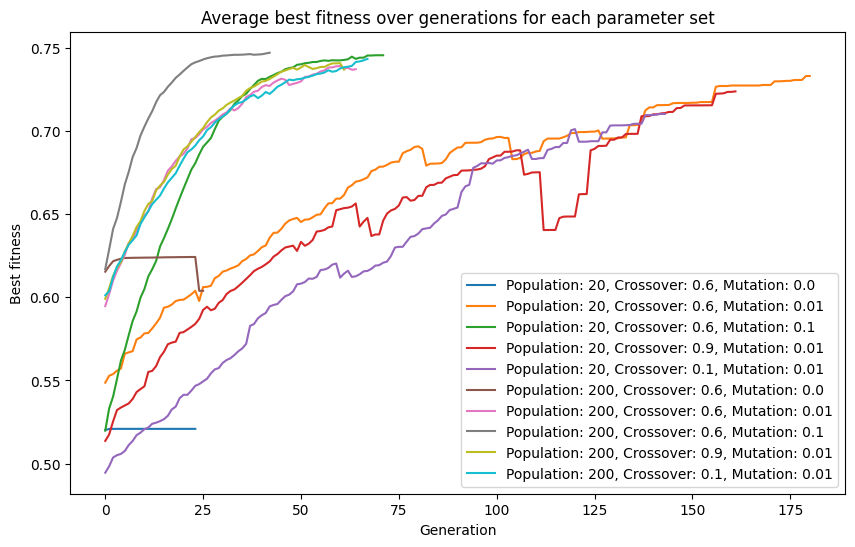

[[30.21243957576165, 159.00054552534226, -185.5996182813223, -240.11601094312195, -98.83022786333814, -157.6087050068361, 7.110554472419326, -11.923528561391485, -115.40565050801655, -113.56899272995032, -163.1267926089888, -26.657619815935213], [-31.108170206626724, 70.81280859808244, -39.521323211989326, -59.7435676535931, -69.6544841608806, -60.634793737446174, 59.8974890933673, 94.05775706836694, -160.83120640860872, -133.10935208456115, -169.81215805709255, -247.78298714134303], [-7.677325440634236, 77.73007730045177, -35.412437518389865, -68.76550458275277, -92.63270216044778, -58.801470689668655, 51.18128012765807, 133.04063935678013, -148.95202922114984, -177.56965896540376, -178.8054601133226, -249.9999999999372], [-46.94028628151095, 64.04161082357986, -25.914366134213342, -60.7997030993834, -108.07192369231277, -93.63516388293813, -2.825771674558108, 135.20517248206926, -84.53826314327597, -171.29479037564593, -166.53256475027385, -157.25745604971996], [-10.542630923217535, 

In [5]:
import random
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import pandas as pd
import warnings

warnings.filterwarnings('ignore', category=RuntimeWarning)

# Read the dataset
df = pd.read_csv('/home/lenos/Desktop/NeuralNetworkProject/dataset-HAR-PUC-Rio.csv', delimiter=";", decimal=",")

# Define feature columns
feature_columns = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4']

# Group by 'class' and calculate mean for each feature
mean_df = df.groupby('class')[feature_columns].mean()

# Separate 'sitting' class mean from the others
target_state = 'sitting'
target_mean = mean_df.loc[target_state]
other_states_mean = mean_df.drop(target_state)



class GeneticAlgorithm:
    upper_bound = 250   # global upper bound
    lower_bound = -upper_bound  # global lower bound


    def __init__(self, target_state, other_states, population_size, crossover_prob, mutation_prob):
        self.target_state = target_state
        self.other_states = other_states
        self.population_size = population_size
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.population = self.initialize_population()
        self.best_individual = None
        self.best_fitness = float('-inf')
        self.fitness_history = []

    def initialize_population(self):
        return [[random.uniform(self.lower_bound, self.upper_bound) for _ in range(len(self.target_state))] for _ in range(self.population_size)]

    def calculate_fitness(self, individual): #fitness function
        C = 0.4
        cosine_sim_target = max(0,cosine_similarity([individual], [self.target_state])[0][0])
        cosine_sims_other_states = [max(0,cosine_similarity([individual], [other_state])[0][0]) for other_state in self.other_states]
        mean_cosine_sim_other_states = np.mean(cosine_sims_other_states)
        fitness = (cosine_sim_target + C * (1 - mean_cosine_sim_other_states)) / (1 + C)
        return fitness

    def select_parents(self):# Select two parents using 2 tournaments
        tournament = random.choices(self.population, k=5)
        parent1 = max(tournament, key=self.calculate_fitness)
        tournament = random.choices(self.population, k=5)
        parent2 = max(tournament, key=self.calculate_fitness)
        return parent1, parent2
    
    def sbx(self, parent1, parent2, eta):
        r = random.random()
        if r <= 0.5:
            B = (2 * r) ** (1 / (eta + 1))
        else:
            B = (1 / (2 * (1 - r))) ** (1 / (eta + 1))
            
        child1 = 0.5 * ((1 + B) * parent1 + (1 - B) * parent2)
        child2 = 0.5 * ((1 - B) * parent1 + (1 + B) * parent2)
    
        return child1, child2



    def crossover(self, parent1, parent2, eta=20):
        if random.random() < self.crossover_prob:
            child1, child2 = [], []
            for gene1, gene2 in zip(parent1, parent2):
                c1, c2 = self.sbx(gene1, gene2, eta)
                c1 = max(min(c1, self.upper_bound), self.lower_bound)
                c2 = max(min(c2, self.upper_bound), self.lower_bound)
                child1.append(c1)
                child2.append(c2)
        else:
            child1, child2 = parent1, parent2
        return child1, child2


    def mutate(self, individual, eta=20):# Polynomial Mutation
        def mutate_gene(gene):
            rnd = random.random()
            delta_q = None
            if rnd < 0.5:
                delta_q = (2*rnd)**(1/(eta+1)) - 1
            else:
                delta_q = 1 - (2*(1 - rnd))**(1/(eta+1))

            gene = gene + delta_q * (self.upper_bound - self.lower_bound)
            gene = max(min(gene, self.upper_bound), self.lower_bound)  
            return gene

        mutated_individual = [mutate_gene(gene) if random.random() < self.mutation_prob else gene for gene in individual]

        return mutated_individual


    def run(self, max_generations, improvement_generations, improvement_rate):# Run the genetic algorithm once
        stagnant_generations = 0
        prev_best_fitness = self.best_fitness

        for generation in range(max_generations):
            new_population = []
            for _ in range(self.population_size // 2):
                parent1, parent2 = self.select_parents()
                child1, child2 = self.crossover(parent1, parent2)
                new_population.append(self.mutate(child1))
                new_population.append(self.mutate(child2))

            self.population = new_population
            current_best_fitness = max(self.calculate_fitness(individual) for individual in self.population)
            #print(generation)
            if current_best_fitness > self.best_fitness:
                self.best_fitness = current_best_fitness
                improvement = (self.best_fitness - prev_best_fitness) / prev_best_fitness
                self.best_individual = max(self.population, key=self.calculate_fitness)  
                if(improvement>improvement_rate):
                    #print("not stagnant",improvement)
                    stagnant_generations = 0
                else:
                    #print("stagnant" ,improvement)
                    stagnant_generations += 1
            else:
                stagnant_generations += 1
            
            if stagnant_generations >= improvement_generations:
                break

            self.fitness_history.append(self.best_fitness)
            prev_best_fitness = self.best_fitness

        return self.best_individual, self.best_fitness, self.fitness_history  



def pad_histories(histories, max_len):
    return [np.pad(history, (0, max_len - len(history)), mode='constant', constant_values=np.nan) for history in histories]

def evaluate_parameters(target_state, other_states, parameters, runs=10, max_generations=200, improvement_generations=25, improvement_rate=0.01):
    results = []
    top_individuals = []  # Initialize list for top individuals
    for i, (population_size, crossover_prob, mutation_prob) in enumerate(parameters):
        print(f"Running parameter set {i + 1}...")
        best_individuals = []
        fitnesses = []
        histories = []
        for _ in range(runs):
            ga = GeneticAlgorithm(target_state, other_states, population_size, crossover_prob, mutation_prob)
            best_individual, best_fitness, fitness_history = ga.run(max_generations, improvement_generations, improvement_rate)  # Get the best individual
            best_individuals.append(best_individual)
            fitnesses.append(best_fitness)
            histories.append(fitness_history)
        avg_fitness = np.mean(fitnesses)

        avg_generations = np.mean([len(hist) for hist in histories])

        max_len = max(len(history) for history in histories)
        padded_histories = pad_histories(histories, max_len)
        
        avg_history = np.nanmean(padded_histories, axis=0)
        
        best_individual = max(best_individuals, key=ga.calculate_fitness)  # Get the overall best individual
        top_individuals.append(best_individual)  # Append the best individual to the list

        results.append((best_individual, avg_fitness, avg_history))
        # print("Target mean:")
        # print(" ".join(map(str, target_state)))
        print("Best individual:")
        print(" ".join(map(str, best_individual)))         
        print(f"Average fitness: {avg_fitness}")
        print(f"Average number of generations: {avg_generations}")
    return results,top_individuals


def plot_results(results, parameters):
    plt.figure(figsize=(10, 6))
    for i, (best_individual, avg_fitness, avg_history) in enumerate(results):
        plt.plot(avg_history, label=f"Population: {parameters[i][0]}, Crossover: {parameters[i][1]}, Mutation: {parameters[i][2]}")
    plt.title("Average best fitness over generations for each parameter set")
    plt.xlabel("Generation")
    plt.ylabel("Best fitness")
    plt.legend()
    plt.show()


target_state = target_mean.values
other_states = other_states_mean.values
# Define parameters as list of tuples: (population size, crossover probability, mutation probability)
parameters = [
    (20, 0.6, 0.00),
    (20, 0.6, 0.01),
    (20, 0.6, 0.10),
    (20, 0.9, 0.01),
    (20, 0.1, 0.01),
    (200, 0.6, 0.00),
    (200, 0.6, 0.01),
    (200, 0.6, 0.10),
    (200, 0.9, 0.01),
    (200, 0.1, 0.01)
]

results,top_individuals = evaluate_parameters(target_state, other_states, parameters)
plot_results(results, parameters)
print(top_individuals)

In [6]:
import pandas as pd
import scipy.stats as stats
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import tensorflow as tf
from tensorflow import keras
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical
from sklearn.preprocessing import MinMaxScaler

def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

df = pd.read_csv('/home/lenos/Desktop/NeuralNetworkProject/dataset-HAR-PUC-Rio.csv',delimiter=";",decimal=",")

df['gender'] = df['gender'].replace(['Woman'], '0')
df['gender'] = df['gender'].replace(['Man'], '1')

activities = df['class'].unique()
print(activities)
for count,value in enumerate(activities):
    df['class'] = df['class'].replace([value], count)

df= df.drop(['user'],axis=1)
scaler = MinMaxScaler(feature_range=(0,1))
columns = ['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4']

df= df.dropna()
df[columns] = df[columns].astype("float")
print(df.describe())
df[columns] = df[columns].apply(lambda x: scaler.fit_transform(x.values.reshape(-1,1)).flatten())
# df[columns] = df[columns].apply(stats.zscore)
df = df.sample(frac=1)
features= df[['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4']].values
features = features.astype("float32")
labels = df['class'].values
p = pd.DataFrame(features,columns= ['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4'])
p.describe()
# print(top_individuals)


['sitting' 'sittingdown' 'standing' 'standingup' 'walking']
                 age  how_tall_in_meters         weight  body_mass_index  \
count  165632.000000       165632.000000  165632.000000    165632.000000   
mean       38.264925            1.639712      70.819431        26.188535   
std        13.183821            0.052820      11.296557         2.995781   
min        28.000000            1.580000      55.000000        22.000000   
25%        28.000000            1.580000      55.000000        22.000000   
50%        31.000000            1.620000      75.000000        28.400000   
75%        46.000000            1.710000      83.000000        28.600000   
max        75.000000            1.710000      83.000000        28.600000   

                  x1             y1             z1             x2  \
count  165632.000000  165632.000000  165632.000000  165632.000000   
mean       -6.649319      88.293591     -93.164449     -87.827956   
std        11.616273      23.895881      39.4094

,x1,y1,z1,x2,y2,z2,x3,y3,z3,x4,y4,z4
count,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000,165632.000000
mean,0.367301,0.446883,0.502796,0.420033,0.572579,0.598030,0.513344,0.596791,0.507447,0.775557,0.708129,0.763864
std,0.014253,0.029721,0.038865,0.175218,0.252660,0.260916,0.052322,0.052938,0.044369,0.055604,0.032629,0.026763
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.360736,0.434080,0.476331,0.474664,0.600985,0.644114,0.504970,0.587488,0.498534,0.743106,0.691176,0.748988
50%,0.368098,0.453980,0.498028,0.501551,0.669951,0.675237,0.517893,0.599218,0.511241,0.775036,0.710784,0.763158
75%,0.375460,0.462687,0.531558,0.514995,0.742611,0.795670,0.529821,0.611926,0.521017,0.796807,0.728758,0.777328
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [7]:
from keras.optimizers import SGD
from keras.callbacks import EarlyStopping
from keras.losses import CategoricalCrossentropy
from keras.utils import to_categorical

def create_and_train_model(features, labels, num_classes, learning_rate=0.01, momentum=0.6):
    model = Sequential()
    model.add(Dense(22, input_shape=(12,), activation='relu')) 
    model.add(Dense(11, activation='relu'))
    model.add(Dense(11, activation='relu'))
    model.add(Dense(num_classes, activation='softmax')) 

    sgd = SGD(lr=learning_rate, momentum=momentum)
    model.compile(loss=CategoricalCrossentropy(), optimizer=sgd, metrics=['accuracy'])

    early_stop = EarlyStopping(monitor='val_loss', patience=4, verbose=0)
    model.fit(features, labels, epochs=30, validation_split=0.1, callbacks=[early_stop])

    return model


# Convert labels to categorical one-hot encoding
one_hot_labels = to_categorical(labels, num_classes=5)

model = create_and_train_model(features, one_hot_labels, num_classes=5)




Epoch 1/30


/home/lenos/miniconda3/lib/python3.10/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


4659/4659 [==============================] - 13s 3ms/step - loss: 0.8381 - accuracy: 0.6829 - val_loss: 0.6761 - val_accuracy: 0.7488
Epoch 2/30
4659/4659 [==============================] - 13s 3ms/step - loss: 0.6400 - accuracy: 0.7471 - val_loss: 0.5766 - val_accuracy: 0.7876
Epoch 3/30
4659/4659 [==============================] - 13s 3ms/step - loss: 0.5461 - accuracy: 0.7854 - val_loss: 0.5300 - val_accuracy: 0.7964
Epoch 4/30
4659/4659 [==============================] - 13s 3ms/step - loss: 0.4801 - accuracy: 0.8174 - val_loss: 0.4448 - val_accuracy: 0.8377
Epoch 5/30
4659/4659 [==============================] - 13s 3ms/step - loss: 0.4468 - accuracy: 0.8390 - val_loss: 0.3918 - val_accuracy: 0.8514
Epoch 6/30
4659/4659 [==============================] - 13s 3ms/step - loss: 0.4159 - accuracy: 0.8547 - val_loss: 0.6696 - val_accuracy: 0.6934
Epoch 7/30
4659/4659 [==============================] - 13s 3ms/step - loss: 0.3897 - accuracy: 0.8675 - val_loss: 0.6172 - val_accuracy: 0.7

In [8]:
import numpy as np
from sklearn.metrics import mean_squared_error

parameter_sets = top_individuals

df = pd.read_csv('/home/lenos/Desktop/NeuralNetworkProject/dataset-HAR-PUC-Rio.csv',delimiter=";",decimal=",")
# Fit the scaler to the columns of the dataframe
print(columns)
scaler2 = MinMaxScaler(feature_range=(0,1))
scaler2.fit(df[columns].values)

normalized_parameter_sets = scaler2.transform(parameter_sets)



# Group by 'class' and calculate mean for each feature
mean_df = df.groupby('class')[columns].mean()

# Normalize the mean values
normalized_means = scaler2.transform(mean_df.values)




# Perform prediction for each normalized mean
for class_name, mean_values in zip(mean_df.index, normalized_means):
    mean_values = np.array(mean_values).reshape(1, -1)  # Reshape as model.predict expects a 2D array
    prediction = model.predict(mean_values)

    # We take the class with the highest probability
    class_idx = np.argmax(prediction)
    print(f"The predicted class for the mean parameters of class {class_name} is: {activities[class_idx]}")
    print(f"Probability of class : {prediction[0][class_idx]}")

# Perform prediction for each normalized parameter set
for params in normalized_parameter_sets:
    params = np.array(params).reshape(1, -1)  # Reshape as model.predict expects a 2D array
    prediction = model.predict(params)

    # We take the class with the highest probability
    class_idx = np.argmax(prediction)
    print(f"The predicted class for parameters {params} is: {activities[class_idx]}")
    print(f"Probability of sitting: {prediction[0][0]}")


['x1', 'y1', 'z1', 'x2', 'y2', 'z2', 'x3', 'y3', 'z3', 'x4', 'y4', 'z4']
1/1 [==============================] - 0s 64ms/step
The predicted class for the mean parameters of class sitting is: sitting
Probability of class : 0.9996428489685059
1/1 [==============================] - 0s 23ms/step
The predicted class for the mean parameters of class sittingdown is: sittingdown
Probability of class : 0.9910242557525635
1/1 [==============================] - 0s 24ms/step
The predicted class for the mean parameters of class standing is: standing
Probability of class : 0.7027746438980103
1/1 [==============================] - 0s 23ms/step
The predicted class for the mean parameters of class standingup is: sittingdown
Probability of class : 0.9857211112976074
1/1 [==============================] - 0s 24ms/step
The predicted class for the mean parameters of class walking is: walking
Probability of class : 0.9934645295143127
1/1 [==============================] - 0s 23ms/step
The predicted class for